## Compilation of Imports

In [2]:
import pandas as pd
import numpy as np
from itertools import combinations

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_predict
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
df = pd.read_excel("./static/resolved_nan.xlsx")

In [4]:
x = df.drop(["diagnosed_diabetes"], axis=1)
y = df["diagnosed_diabetes"]

## Train Test Split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.3,
    train_size= 0.7,
    random_state=0
    )

In [7]:
print(x_train.shape)
print(x_test.shape)

(178321, 15)
(76424, 15)


In [8]:
x_train_encoded = x_train.copy()
x_test_encoded = x_test.copy()
x_base_encoded = x.copy()
y_base = y.copy()

## Label Encoding for Ordinal Data

In [9]:
ordinal_columns = [
    'age_grp', 
    'bmi_grp', 
    'education', 
    'income_grp', 
    'gen_health', 
    'phy_activeness', 
    'smoke'
]

# Define predefined mappings for each ordinal column
predefined_mappings = {
    'age_grp': {1:0, 2:1, 3:2, 4:3, 5:4, 6:5, 7:6, 8:7, 9:8, 10:9, 11:10, 12:11, 13:12},
    'bmi_grp': {1:0, 2:1, 3:2, 4:3},
    'education': {1:0, 2:1, 3:2, 4:3},
    'income_grp': {1:0, 2:1, 3:2, 4:3, 5:4},
    'gen_health': {1:0, 2:1},
    'phy_activeness': {1:0, 2:1, 3:2, 4:3},
    'smoke': {1:0, 2:1, 3:2, 4:3}
}

# Apply predefined mapping to training and test datasets
for col in ordinal_columns:
    # Get the predefined mapping for the column
    mapping = predefined_mappings[col]
    
    # Map the training data using the predefined mapping
    x_train_encoded[col] = x_train_encoded[col].map(mapping)
    x_test_encoded[col] = x_test_encoded[col].map(mapping)
    x_base_encoded[col] = x_base_encoded[col].map(mapping)
    
    # Check for unseen categories
    unseen_classes = set(x_test_encoded[col][x_test_encoded[col].isnull()].index)
    if unseen_classes:
        print(f"Unseen classes in column '{col}': {unseen_classes}")

## One Hot Encoding for Nominal Data

In [10]:
sex_mapping = {
    1: 'Male', 
    2: 'Female'
}
race_cat_mapping = {
    1: 'White only, non-Hispanic',
    2: 'Black only, non-Hispanic',
    3: 'American Indian or Alaskan Native only, Non-Hispanic',
    4: 'Asian only, non-Hispanic',
    5: 'Native Hawaiian or other Pacific Islander only, Non-Hispanic',
    6: 'Other race only, non-Hispanic',
    7: 'Multiracial, non-Hispanic',
    8: 'Hispanic'
} 
drink_mapping = {
    1: 'No',
    2: 'Yes'
}
high_bp_mapping = {
    1: 'No',
    2: 'Yes'
}
high_chol_mapping = {
    1: 'No',
    2: 'Yes'
}
stroke_mapping = {
    1: 'Yes',
    2: 'No'
}
heart_disease_attack_mapping = {
    1: 'Yes',
    2: 'No'
}
kidney_disease_mapping = {
    1: 'Yes',
    2: 'No'
}

nominal_columns = [
    'sex', 
    'race_cat', 
    'drink', 
    'high_bp', 
    'high_chol', 
    'stroke', 
    'heart_disease_attack', 
    'kidney_disease',
]

# Initialize the OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)

# Fit on training data and transform both training and test data
one_hot_encoded_train_data = one_hot_encoder.fit_transform(x_train_encoded[nominal_columns])
one_hot_encoded_test_data = one_hot_encoder.transform(x_test_encoded[nominal_columns])
one_hot_encoded_base_data = one_hot_encoder.transform(x_base_encoded[nominal_columns])

# Generate feature names based on the original mappings
columns = []
for feature, categories in zip(nominal_columns, one_hot_encoder.categories_):
    if feature == 'sex':
        columns.extend([f"{feature}_{sex_mapping[int(cat)]}" for cat in categories])
    elif feature == 'race_cat':
        columns.extend([f"{feature}_{race_cat_mapping[int(cat)]}" for cat in categories])
    elif feature == 'drink':
        columns.extend([f"{feature}_{drink_mapping[int(cat)]}" for cat in categories])
    elif feature == 'high_bp':
        columns.extend([f"{feature}_{high_bp_mapping[int(cat)]}" for cat in categories])
    elif feature == 'high_chol':
        columns.extend([f"{feature}_{high_chol_mapping[int(cat)]}" for cat in categories])
    elif feature == 'stroke':
        columns.extend([f"{feature}_{stroke_mapping[int(cat)]}" for cat in categories])
    elif feature == 'heart_disease_attack':
        columns.extend([f"{feature}_{heart_disease_attack_mapping[int(cat)]}" for cat in categories])
    elif feature == 'kidney_disease':
        columns.extend([f"{feature}_{kidney_disease_mapping[int(cat)]}" for cat in categories])

# Convert one-hot encoded data to DataFrame for both training and test sets
one_hot_encoded_train_df = pd.DataFrame(one_hot_encoded_train_data, columns=columns, index=x_train_encoded.index)
one_hot_encoded_test_df = pd.DataFrame(one_hot_encoded_test_data, columns=columns, index=x_test_encoded.index)
one_hot_encoded_base_df = pd.DataFrame(one_hot_encoded_base_data, columns=columns, index=x_base_encoded.index)

# Concatenate the ordinal columns with the one-hot encoded columns for both datasets
x_train_encoded = pd.concat([x_train_encoded[ordinal_columns], one_hot_encoded_train_df], axis=1)
x_test_encoded = pd.concat([x_test_encoded[ordinal_columns], one_hot_encoded_test_df], axis=1)
x_base_encoded = pd.concat([x_base_encoded[ordinal_columns], one_hot_encoded_base_df], axis=1)

# Display the first few rows of the encoded training and test data
print("Encoded Training Data:")
print(x_train_encoded.head())

print("\nEncoded Test Data:")
print(x_test_encoded.head())

print("\nEncoded Base Data:")
print(x_base_encoded.head())


Encoded Training Data:
        age_grp  bmi_grp  education  income_grp  gen_health  phy_activeness  \
222463        6        1          3           2           0               0   
213767        3        3          2           4           0               2   
167511        6        1          3           4           0               0   
33510         7        1          2           4           0               3   
197060        5        2          2           4           0               3   

        smoke  sex_Male  sex_Female  race_cat_White only, non-Hispanic  ...  \
222463      3       0.0         1.0                                1.0  ...   
213767      3       1.0         0.0                                0.0  ...   
167511      2       0.0         1.0                                1.0  ...   
33510       2       1.0         0.0                                1.0  ...   
197060      3       1.0         0.0                                1.0  ...   

        high_bp_No  high_bp

## Feature Selection using Recursive Feature Elimination with Cross-Validation (RFECV)

In [12]:
# model to evaluate feature importance
estimator_model = RandomForestClassifier(random_state=42)

# initialization of RFECV
rfecv = RFECV(
    estimator=estimator_model, 
    step=1, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1
)

rfecv.fit(x_base_encoded, y_base)

print('Optimal number of features: ', rfecv.n_features_)

Optimal number of features:  5


In [13]:
selected_features = x_base_encoded.columns[rfecv.support_]
print("Selected Features: ", list(selected_features))

Selected Features:  ['age_grp', 'bmi_grp', 'income_grp', 'gen_health', 'high_bp_No']


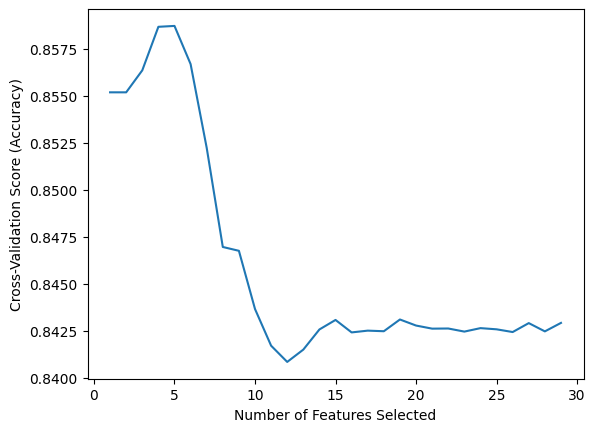

In [14]:
plt.figure()
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross-Validation Score (Accuracy)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score'])+1), rfecv.cv_results_['mean_test_score'])
plt.show()

In [15]:
x_train_featured_encoded = x_train_encoded[['age_grp', 'bmi_grp', 'income_grp', 'gen_health', 'high_bp_No']]
x_test_featured_encoded = x_test_encoded[['age_grp', 'bmi_grp', 'income_grp', 'gen_health', 'high_bp_No']]
x_base_featured_encoded = x_base_encoded[['age_grp', 'bmi_grp', 'income_grp', 'gen_health', 'high_bp_No']]

## Normalization of Dataset with Important Features

In [16]:
scaler = StandardScaler()
x_train_featured_scaled = scaler.fit_transform(x_train_featured_encoded)
x_test_featured_scaled = scaler.transform(x_test_featured_encoded)
x_base_featured_scaled = scaler.transform(x_base_featured_encoded)

## Determining Optimal k-value for KNN

In [14]:
# Define the parameter grid to test range of values of k
param_grid = {'n_neighbors': [pow(k, 2) for k in range(1, 31)]}

# GridSearch with cross-validation to find best value of n_neighbours
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(x_train_featured_scaled, y_train)

best_k = grid.best_params_['n_neighbors']
best_score = grid.best_score_
print(f"Best k: {best_k}, Best cross-validated accuracy: {best_score}")

Best k: 289, Best cross-validated accuracy: 0.8585416165470307


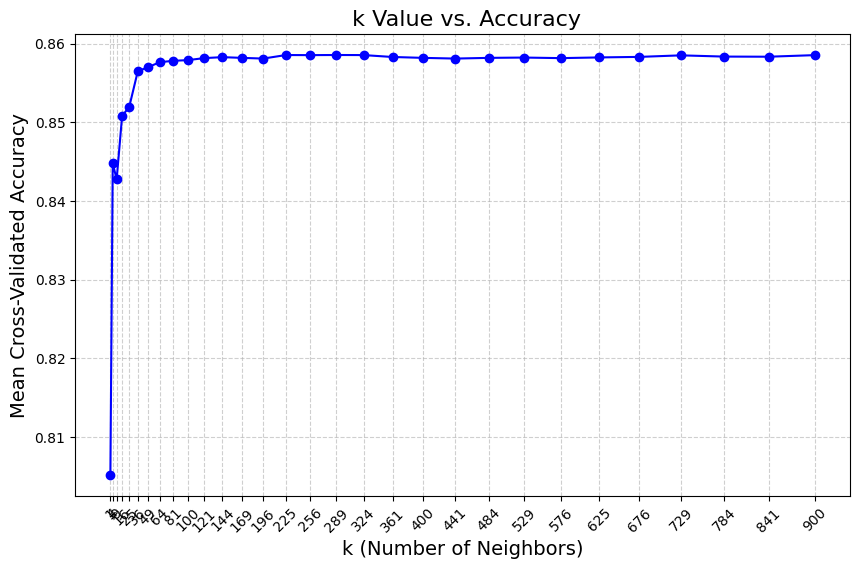

In [15]:
# Retrieve the mean cross-validated accuracy scores for each value of k
mean_scores = grid.cv_results_['mean_test_score']

# Create a list of k values used in the parameter grid
k_values = param_grid['n_neighbors']

# Plot accuracy vs. k
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_scores, marker='o', linestyle='-', color='b')
plt.title(' k Value vs. Accuracy', fontsize=16)
plt.xlabel('k (Number of Neighbors)', fontsize=14)
plt.ylabel('Mean Cross-Validated Accuracy', fontsize=14)
plt.xticks(k_values, rotation=45)  # Ensure all k values are visible
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## K-Nearest Neighbours (KNN) Model

In [16]:
# k-value taken from result of finding optimal k
knn = KNeighborsClassifier(
    algorithm = 'brute', 
    metric = 'euclidean', 
    n_neighbors = 289, 
    weights = 'uniform'
)

In [17]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = [
    'accuracy', 
    'precision_macro', 
    'recall_macro', 
    'f1_macro'
]

cv_results = cross_validate(knn, x_base_featured_scaled, y_base, cv=kfold, scoring=scoring, n_jobs=-1)

# Print the results
print(f"Cross-Validation Accuracy Scores: {cv_results['test_accuracy']}")
print(f"Cross-Validation Precision Scores: {cv_results['test_precision_macro']}")
print(f"Cross-Validation Recall Scores: {cv_results['test_recall_macro']}")
print(f"Cross-Validation F1 Scores: {cv_results['test_f1_macro']}")

print("\n")

# Calculate and print mean scores for each metric
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean()*100:.3f}")
print(f"Mean Precision: {cv_results['test_precision_macro'].mean()*100:.3f}")
print(f"Mean Recall: {cv_results['test_recall_macro'].mean()*100:.3f}")
print(f"Mean F1-Score: {cv_results['test_f1_macro'].mean()*100:.3f}")

Cross-Validation Accuracy Scores: [0.85958508 0.8588196  0.85870184 0.85999725 0.85807376]
Cross-Validation Precision Scores: [0.70502749 0.70632599 0.71332495 0.71873989 0.70906952]
Cross-Validation Recall Scores: [0.56219242 0.56334491 0.56312866 0.56536743 0.56494957]
Cross-Validation F1 Scores: [0.57576186 0.57725876 0.57682494 0.58022118 0.57937752]


Mean Accuracy: 85.904
Mean Precision: 71.050
Mean Recall: 56.380
Mean F1-Score: 57.789


In [18]:
param_grid = {
    'n_neighbors' : [289], # k-value taken from result of finding optimal k
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan', 'minkowski'],  
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='accuracy', 
    cv=5, 
    verbose=1,  
    n_jobs=-1  
)

# Fit the model
grid_search.fit(x_train_featured_scaled, y_train)

# Best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'algorithm': 'brute', 'metric': 'euclidean', 'n_neighbors': 289, 'weights': 'uniform'}
Best Cross-Validated Accuracy: 0.8587154610059953


## Decision Tree (DT) Model

In [19]:
dt = DecisionTreeClassifier(
    criterion = 'gini', 
    max_depth = 5, 
    min_samples_leaf = 1, 
    min_samples_split = 2
)

In [20]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = [
    'accuracy', 
    'precision_macro', 
    'recall_macro', 
    'f1_macro'
]

cv_results = cross_validate(dt, x_base_featured_scaled, y_base, cv=kfold, scoring=scoring, n_jobs=-1)

# Print the results
print(f"Cross-Validation Accuracy Scores: {cv_results['test_accuracy']}")
print(f"Cross-Validation Precision Scores: {cv_results['test_precision_macro']}")
print(f"Cross-Validation Recall Scores: {cv_results['test_recall_macro']}")
print(f"Cross-Validation F1 Scores: {cv_results['test_f1_macro']}")

print("\n")

# Calculate and print mean scores for each metric
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean()*100:.3f}")
print(f"Mean Precision: {cv_results['test_precision_macro'].mean()*100:.3f}")
print(f"Mean Recall: {cv_results['test_recall_macro'].mean()*100:.3f}")
print(f"Mean F1-Score: {cv_results['test_f1_macro'].mean()*100:.3f}")

Cross-Validation Accuracy Scores: [0.85893737 0.8588196  0.85858407 0.8597421  0.85830929]
Cross-Validation Precision Scores: [0.6998274  0.70454393 0.71143888 0.71318028 0.70869882]
Cross-Validation Recall Scores: [0.57082336 0.57407848 0.56613573 0.57645239 0.57307561]
Cross-Validation F1 Scores: [0.58770513 0.59206119 0.5811279  0.5954316  0.59066173]


Mean Accuracy: 85.888
Mean Precision: 70.754
Mean Recall: 57.211
Mean F1-Score: 58.940


In [21]:
# Define parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt = DecisionTreeClassifier(random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(x_train_featured_encoded, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Use the best model
best_model = grid_search.best_estimator_

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}


## Support Vector Machine (SVM) Model

In [22]:
# hyperparameter tuning not done for SVM as it was too computationally expansive
# set to linear kernel as it is less computationally expansive

svm = SVC(kernel='linear', C = 1, random_state=42)

In [23]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = [
    'accuracy', 
    'precision_macro', 
    'recall_macro', 
    'f1_macro'
]

cv_results = cross_validate(svm, x_base_featured_scaled, y_base, cv=kfold, scoring=scoring, n_jobs=-1)

# Print the results
print(f"Cross-Validation Accuracy Scores: {cv_results['test_accuracy']}")
print(f"Cross-Validation Precision Scores: {cv_results['test_precision_macro']}")
print(f"Cross-Validation Recall Scores: {cv_results['test_recall_macro']}")
print(f"Cross-Validation F1 Scores: {cv_results['test_f1_macro']}")

print("\n")

# Calculate and print mean scores for each metric
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean()*100:.3f}")
print(f"Mean Precision: {cv_results['test_precision_macro'].mean()*100:.3f}")
print(f"Mean Recall: {cv_results['test_recall_macro'].mean()*100:.3f}")
print(f"Mean F1-Score: {cv_results['test_f1_macro'].mean()*100:.3f}")

Cross-Validation Accuracy Scores: [0.85668021 0.8556007  0.85442305 0.85493336 0.85428566]
Cross-Validation Precision Scores: [0.4283401  0.42780035 0.42721153 0.42746668 0.42714283]
Cross-Validation Recall Scores: [0.5 0.5 0.5 0.5 0.5]
Cross-Validation F1 Scores: [0.46140429 0.46109096 0.46074872 0.46089708 0.46070877]


Mean Accuracy: 85.518
Mean Precision: 42.759
Mean Recall: 50.000
Mean F1-Score: 46.097


## Naive Bayes (NB) Model

In [24]:
nb_model = GaussianNB(var_smoothing = 0.001)

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = [
    'accuracy', 
    'precision_macro', 
    'recall_macro', 
    'f1_macro'
]

cv_results = cross_validate(
    nb_model, 
    x_base_featured_scaled, 
    y_base, 
    cv=kfold, 
    scoring=scoring, 
    n_jobs=-1
)

# Print the results
print(f"Cross-Validation Accuracy Scores: {cv_results['test_accuracy']}")
print(f"Cross-Validation Precision Scores: {cv_results['test_precision_macro']}")
print(f"Cross-Validation Recall Scores: {cv_results['test_recall_macro']}")
print(f"Cross-Validation F1 Scores: {cv_results['test_f1_macro']}")

print("\n")

# Calculate and print mean scores for each metric
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean()*100:.3f}")
print(f"Mean Precision: {cv_results['test_precision_macro'].mean()*100:.3f}")
print(f"Mean Recall: {cv_results['test_recall_macro'].mean()*100:.3f}")
print(f"Mean F1-Score: {cv_results['test_f1_macro'].mean()*100:.3f}")

Cross-Validation Accuracy Scores: [0.82855404 0.83004573 0.83006536 0.83106636 0.83220475]
Cross-Validation Precision Scores: [0.65134551 0.65563954 0.65618374 0.65986491 0.6583365 ]
Cross-Validation Recall Scores: [0.65201789 0.65488249 0.65235234 0.66056458 0.64996849]
Cross-Validation F1 Scores: [0.65168018 0.65525915 0.65421988 0.6602132  0.6539256 ]


Mean Accuracy: 83.039
Mean Precision: 65.627
Mean Recall: 65.396
Mean F1-Score: 65.506


In [26]:
# Define parameter grid
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}

nb = GaussianNB()

# GridSearchCV
grid_search = GridSearchCV(
    estimator=nb, 
    param_grid=param_grid, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1
)

grid_search.fit(x_train_featured_encoded, y_train)

# Results
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Best Parameters: {'var_smoothing': 0.001}
Best Cross-Validated Accuracy: 0.833558580333907


## Bagging - Random Forest (RF)

In [27]:
rf = RandomForestClassifier(
    max_depth = 10, 
    min_samples_leaf = 4, 
    min_samples_split = 5, 
    n_estimators = 50
)

Confusion Matrix:
[[213245   4609]
 [ 31292   5599]]


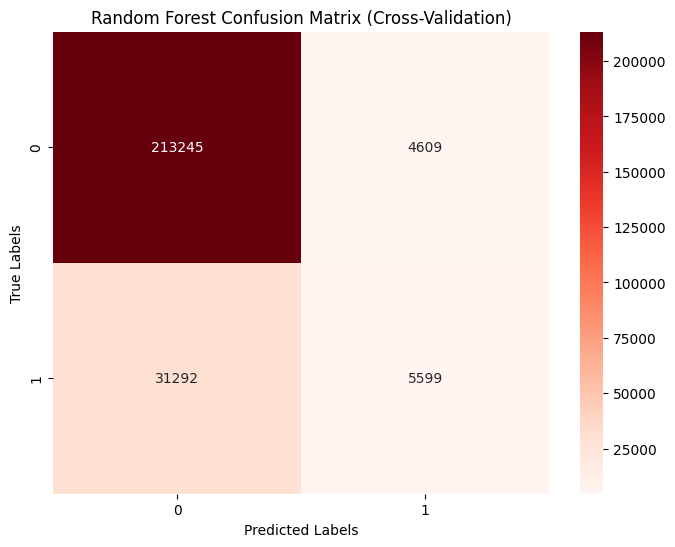

Cross-Validation Accuracy Scores: [0.85919253 0.85889811 0.85889811 0.8598206  0.85825041]
Cross-Validation Precision Scores: [0.70231444 0.70599805 0.71461332 0.71724485 0.71030225]
Cross-Validation Recall Scores: [0.56190629 0.56757123 0.56363501 0.56571349 0.56499709]
Cross-Validation F1 Scores: [0.57531725 0.58324081 0.57757489 0.58069848 0.57946292]


Mean Accuracy: 85.901
Mean Precision: 71.009
Mean Recall: 56.476
Mean F1-Score: 57.926


In [28]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = [
    'accuracy', 
    'precision_macro', 
    'recall_macro', 
    'f1_macro'
]

rf_pred_cv = cross_val_predict(rf, x_base_featured_scaled, y_base, cv=kfold)
cm = confusion_matrix(y_base, rf_pred_cv)

print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=np.unique(y_base), yticklabels=np.unique(y_base))
plt.title("Random Forest Confusion Matrix (Cross-Validation)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

cv_results = cross_validate(rf, x_base_featured_scaled, y_base, cv=kfold, scoring=scoring, n_jobs=-1)

# Print the results
print(f"Cross-Validation Accuracy Scores: {cv_results['test_accuracy']}")
print(f"Cross-Validation Precision Scores: {cv_results['test_precision_macro']}")
print(f"Cross-Validation Recall Scores: {cv_results['test_recall_macro']}")
print(f"Cross-Validation F1 Scores: {cv_results['test_f1_macro']}")

print("\n")

# Calculate and print mean scores for each metric
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean()*100:.3f}")
print(f"Mean Precision: {cv_results['test_precision_macro'].mean()*100:.3f}")
print(f"Mean Recall: {cv_results['test_recall_macro'].mean()*100:.3f}")
print(f"Mean F1-Score: {cv_results['test_f1_macro'].mean()*100:.3f}")

In [29]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    verbose=2
)

# Fit the model
grid_search.fit(x_train_featured_encoded, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Best model
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


## Bagging - K-Nearest Neighbor (KNN)

In [30]:
knn_base = KNeighborsClassifier(n_neighbors=289)

bagging_clf_knn =  BaggingClassifier(
    estimator=knn_base,
    n_estimators=10,  
    max_samples=0.8,  
    random_state=42
)

In [31]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = [
    'accuracy', 
    'precision_macro', 
    'recall_macro', 
    'f1_macro'
]

cv_results = cross_validate(bagging_clf_knn, x_base_featured_scaled, y_base, cv=kfold, scoring=scoring, n_jobs=-1)

# Print the results
print(f"Cross-Validation Accuracy Scores: {cv_results['test_accuracy']}")
print(f"Cross-Validation Precision Scores: {cv_results['test_precision_macro']}")
print(f"Cross-Validation Recall Scores: {cv_results['test_recall_macro']}")
print(f"Cross-Validation F1 Scores: {cv_results['test_f1_macro']}")

print("\n")

# Calculate and print mean scores for each metric
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean()*100:.3f}")
print(f"Mean Precision: {cv_results['test_precision_macro'].mean()*100:.3f}")
print(f"Mean Recall: {cv_results['test_recall_macro'].mean()*100:.3f}")
print(f"Mean F1-Score: {cv_results['test_f1_macro'].mean()*100:.3f}")

Cross-Validation Accuracy Scores: [0.85954582 0.8586037  0.85842705 0.85966359 0.85803451]
Cross-Validation Precision Scores: [0.70359926 0.70494279 0.71061205 0.71581856 0.71010042]
Cross-Validation Recall Scores: [0.56958196 0.56271031 0.56520494 0.56635188 0.56062526]
Cross-Validation F1 Scores: [0.58612923 0.57632776 0.57978775 0.58159111 0.57310512]


Mean Accuracy: 85.885
Mean Precision: 70.901
Mean Recall: 56.489
Mean F1-Score: 57.939


## Bagging - Decision Tree (DT)

In [32]:
dt_base = DecisionTreeClassifier(
    criterion = 'gini', 
    max_depth = 10, 
    min_samples_leaf = 4, 
    min_samples_split = 2
)

bagging_clf_dt =  BaggingClassifier(
    estimator=dt_base,
    n_estimators=10,  
    max_samples=0.8,  
    random_state=42
)

In [33]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = [
    'accuracy', 
    'precision_macro', 
    'recall_macro', 
    'f1_macro'
]

cv_results = cross_validate(bagging_clf_dt, x_base_featured_encoded, y_base, cv=kfold, scoring=scoring, n_jobs=-1)

# Print the results
print(f"Cross-Validation Accuracy Scores: {cv_results['test_accuracy']}")
print(f"Cross-Validation Precision Scores: {cv_results['test_precision_macro']}")
print(f"Cross-Validation Recall Scores: {cv_results['test_recall_macro']}")
print(f"Cross-Validation F1 Scores: {cv_results['test_f1_macro']}")

print("\n")

# Calculate and print mean scores for each metric
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean()*100:.3f}")
print(f"Mean Precision: {cv_results['test_precision_macro'].mean()*100:.3f}")
print(f"Mean Recall: {cv_results['test_recall_macro'].mean()*100:.3f}")
print(f"Mean F1-Score: {cv_results['test_f1_macro'].mean()*100:.3f}")

Cross-Validation Accuracy Scores: [0.85931029 0.85905513 0.85876072 0.85976172 0.8581719 ]
Cross-Validation Precision Scores: [0.70304306 0.70724804 0.71350248 0.71518851 0.71042326]
Cross-Validation Recall Scores: [0.56248819 0.56653314 0.56383424 0.57000421 0.56277255]
Cross-Validation F1 Scores: [0.57616468 0.58181069 0.57785169 0.58672657 0.57625398]


Mean Accuracy: 85.901
Mean Precision: 70.988
Mean Recall: 56.513
Mean F1-Score: 57.976


## Bagging - Naive Bayes (NB)

In [34]:
nb_base = MultinomialNB()

bagging_clf_nb = BaggingClassifier(
    estimator=nb_base,           
    n_estimators=10,            
    max_samples=0.8,            
    max_features=1.0,           
    bootstrap=True,             
    bootstrap_features=False,   
    random_state=42
)

In [35]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = [
    'accuracy', 
    'precision_macro', 
    'recall_macro', 
    'f1_macro'
]

cv_results = cross_validate(bagging_clf_nb, x_base_featured_encoded, y_base, cv=kfold, scoring=scoring, n_jobs=-1)

# Print the results
print(f"Cross-Validation Accuracy Scores: {cv_results['test_accuracy']}")
print(f"Cross-Validation Precision Scores: {cv_results['test_precision_macro']}")
print(f"Cross-Validation Recall Scores: {cv_results['test_recall_macro']}")
print(f"Cross-Validation F1 Scores: {cv_results['test_f1_macro']}")

print("\n")

# Calculate and print mean scores for each metric
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean()*100:.3f}")
print(f"Mean Precision: {cv_results['test_precision_macro'].mean()*100:.3f}")
print(f"Mean Recall: {cv_results['test_recall_macro'].mean()*100:.3f}")
print(f"Mean F1-Score: {cv_results['test_f1_macro'].mean()*100:.3f}")

Cross-Validation Accuracy Scores: [0.85034054 0.85134154 0.85008538 0.85012463 0.84943767]
Cross-Validation Precision Scores: [0.65757803 0.66533859 0.66539407 0.6623014  0.66131524]
Cross-Validation Recall Scores: [0.5656918  0.56473707 0.56647543 0.56358166 0.56218532]
Cross-Validation F1 Scores: [0.57947332 0.57836182 0.58050075 0.57665394 0.5746756 ]


Mean Accuracy: 85.027
Mean Precision: 66.239
Mean Recall: 56.453
Mean F1-Score: 57.793


## Bagging - Standard Vector Machine (SVM)

In [36]:
svm_base = SVC(kernel='linear', C=1)

bagging_clf_svm =  BaggingClassifier(
    estimator=svm_base,
    n_estimators=10,          
    max_samples=0.8,          
    max_features=1.0,         
    bootstrap=True,           
    bootstrap_features=False, 
    n_jobs=-1,                
    random_state=42
)

In [37]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = [
    'accuracy', 
    'precision_macro', 
    'recall_macro', 
    'f1_macro'
]

cv_results = cross_validate(bagging_clf_svm, x_base_featured_scaled, y_base, cv=kfold, scoring=scoring, n_jobs=-1)

# Print the results
print(f"Cross-Validation Accuracy Scores: {cv_results['test_accuracy']}")
print(f"Cross-Validation Precision Scores: {cv_results['test_precision_macro']}")
print(f"Cross-Validation Recall Scores: {cv_results['test_recall_macro']}")
print(f"Cross-Validation F1 Scores: {cv_results['test_f1_macro']}")

print("\n")

# Calculate and print mean scores for each metric
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean()*100:.3f}")
print(f"Mean Precision: {cv_results['test_precision_macro'].mean()*100:.3f}")
print(f"Mean Recall: {cv_results['test_recall_macro'].mean()*100:.3f}")
print(f"Mean F1-Score: {cv_results['test_f1_macro'].mean()*100:.3f}")

Cross-Validation Accuracy Scores: [0.85668021 0.8556007  0.85442305 0.85493336 0.85428566]
Cross-Validation Precision Scores: [0.4283401  0.42780035 0.42721153 0.42746668 0.42714283]
Cross-Validation Recall Scores: [0.5 0.5 0.5 0.5 0.5]
Cross-Validation F1 Scores: [0.46140429 0.46109096 0.46074872 0.46089708 0.46070877]


Mean Accuracy: 85.518
Mean Precision: 42.759
Mean Recall: 50.000
Mean F1-Score: 46.097


## Boosting - AdaBoost (AB)

In [38]:
base_model = DecisionTreeClassifier(max_depth=1)

adaboost_clf = AdaBoostClassifier(estimator=base_model, n_estimators=50, random_state=42)

In [39]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = [
    'accuracy', 
    'precision_macro', 
    'recall_macro', 
    'f1_macro'
]

cv_results = cross_validate(adaboost_clf, x_base_featured_scaled, y_base, cv=kfold, scoring=scoring, n_jobs=-1)

# Print the results
print(f"Cross-Validation Accuracy Scores: {cv_results['test_accuracy']}")
print(f"Cross-Validation Precision Scores: {cv_results['test_precision_macro']}")
print(f"Cross-Validation Recall Scores: {cv_results['test_recall_macro']}")
print(f"Cross-Validation F1 Scores: {cv_results['test_f1_macro']}")

print("\n")

# Calculate and print mean scores for each metric
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean()*100:.3f}")
print(f"Mean Precision: {cv_results['test_precision_macro'].mean()*100:.3f}")
print(f"Mean Recall: {cv_results['test_recall_macro'].mean()*100:.3f}")
print(f"Mean F1-Score: {cv_results['test_f1_macro'].mean()*100:.3f}")

Cross-Validation Accuracy Scores: [0.85905513 0.85803451 0.85807376 0.85883923 0.85707276]
Cross-Validation Precision Scores: [0.70076138 0.70037607 0.7070746  0.70898886 0.70205895]
Cross-Validation Recall Scores: [0.56752799 0.56915678 0.56997569 0.57019492 0.56659816]
Cross-Validation F1 Scores: [0.58323292 0.58529779 0.58641213 0.58684147 0.58159323]


Mean Accuracy: 85.822
Mean Precision: 70.385
Mean Recall: 56.869
Mean F1-Score: 58.468


## Boosting - Gradient Boost (GB)

In [40]:
gb_clf = GradientBoostingClassifier(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 3,
    subsample = 1.0,
    min_samples_split = 2,
    min_samples_leaf = 1
)

Confusion Matrix:
[[212959   4895]
 [ 31015   5876]]


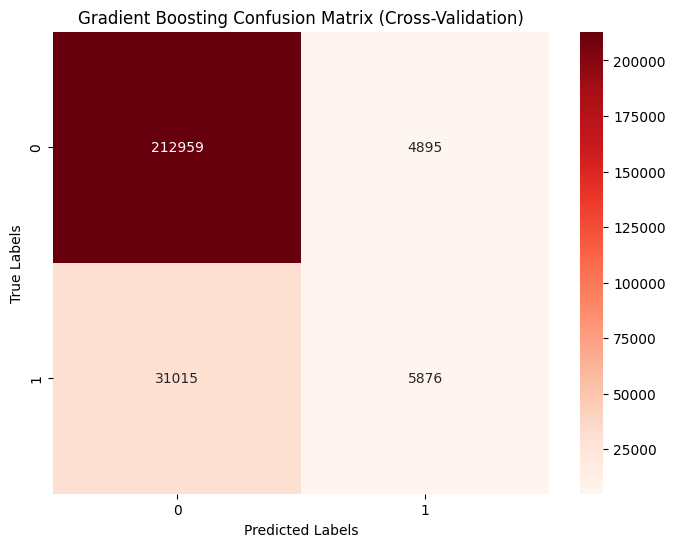

Cross-Validation Accuracy Scores: [0.85929066 0.85893737 0.85889811 0.85985986 0.85819152]
Cross-Validation Precision Scores: [0.70246593 0.70587884 0.71312129 0.71544255 0.70915537]
Cross-Validation Recall Scores: [0.56561277 0.56968439 0.5677736  0.5712412  0.56769984]
Cross-Validation F1 Scores: [0.58059929 0.58616394 0.58347645 0.58844693 0.58327438]


Mean Accuracy: 85.904
Mean Precision: 70.921
Mean Recall: 56.840
Mean F1-Score: 58.439


In [41]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = [
    'accuracy', 
    'precision_macro', 
    'recall_macro', 
    'f1_macro'
]

gb_pred_cv = cross_val_predict(gb_clf, x_base_featured_scaled, y_base, cv=kfold)
cm = confusion_matrix(y_base, gb_pred_cv)

print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=np.unique(y_base), yticklabels=np.unique(y_base))
plt.title("Gradient Boosting Confusion Matrix (Cross-Validation)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

cv_results = cross_validate(gb_clf, x_base_featured_scaled, y_base, cv=kfold, scoring=scoring, n_jobs=-1)

# Print the results
print(f"Cross-Validation Accuracy Scores: {cv_results['test_accuracy']}")
print(f"Cross-Validation Precision Scores: {cv_results['test_precision_macro']}")
print(f"Cross-Validation Recall Scores: {cv_results['test_recall_macro']}")
print(f"Cross-Validation F1 Scores: {cv_results['test_f1_macro']}")

print("\n")

# Calculate and print mean scores for each metric
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean()*100:.3f}")
print(f"Mean Precision: {cv_results['test_precision_macro'].mean()*100:.3f}")
print(f"Mean Recall: {cv_results['test_recall_macro'].mean()*100:.3f}")
print(f"Mean F1-Score: {cv_results['test_f1_macro'].mean()*100:.3f}")

## Boosting - Extreme Gradient Boosting (XGB)

In [42]:
xgb_clf = XGBClassifier(
    objective='binary:logistic',   
    eval_metric='logloss',         
    learning_rate=0.1,             
    max_depth=6,                   
    n_estimators=100,              
    random_state=42                
)

In [43]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = [
    'accuracy', 
    'precision_macro', 
    'recall_macro', 
    'f1_macro'
]

cv_results = cross_validate(xgb_clf, x_base_featured_scaled, y_base, cv=kfold, scoring=scoring, n_jobs=-1)

# Print the results
print(f"Cross-Validation Accuracy Scores: {cv_results['test_accuracy']}")
print(f"Cross-Validation Precision Scores: {cv_results['test_precision_macro']}")
print(f"Cross-Validation Recall Scores: {cv_results['test_recall_macro']}")
print(f"Cross-Validation F1 Scores: {cv_results['test_f1_macro']}")

print("\n")

# Calculate and print mean scores for each metric
print(f"Mean Accuracy: {cv_results['test_accuracy'].mean()*100:.3f}")
print(f"Mean Precision: {cv_results['test_precision_macro'].mean()*100:.3f}")
print(f"Mean Recall: {cv_results['test_recall_macro'].mean()*100:.3f}")
print(f"Mean F1-Score: {cv_results['test_f1_macro'].mean()*100:.3f}")

Cross-Validation Accuracy Scores: [0.85903551 0.85889811 0.85883923 0.859958   0.85836817]
Cross-Validation Precision Scores: [0.70109118 0.70683032 0.7142471  0.71897394 0.71131533]
Cross-Validation Recall Scores: [0.56301204 0.56356027 0.56343277 0.56422106 0.56445154]
Cross-Validation F1 Scores: [0.57689024 0.57757489 0.57727698 0.57856395 0.57869334]


Mean Accuracy: 85.902
Mean Precision: 71.049
Mean Recall: 56.374
Mean F1-Score: 57.780


## Stacking - RF, NB, DT, KNN, SVM

In [44]:
base_models = [
    ('nb', GaussianNB()),
    ('dt', DecisionTreeClassifier(max_depth=5)),
    ('knn', KNeighborsClassifier(n_neighbors=289)),
    ('rf', RandomForestClassifier()), 
    ('svm', SVC(kernel='linear', random_state=42))
]

# Meta-model (stacking model)
meta_model = LogisticRegression()

In [45]:
# Generate all combinations of base models
base_model_combinations = []
for r in range(2, len(base_models) + 1):  # Create combinations of 2 to n models
    base_model_combinations.extend(combinations(base_models, r))

In [46]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = [
    'accuracy', 
    'precision_macro', 
    'recall_macro', 
    'f1_macro'
]

# Loop through each combination of base models and evaluate stacking
for combo in base_model_combinations:
    # Print the current combination of base models
    combo_names = [model[0] for model in combo]
    print(f"Evaluating Stacking Model: {', '.join(combo_names)}")
    
    # Convert combination to list of tuples in the correct format, a list
    base_model_list = list(combo)  
    
    # Create the stacking classifier with the current combination of base models
    stacking_clf = StackingClassifier(estimators=base_model_list, final_estimator=meta_model)
    
    # Run cross-validation
    cv_results = cross_validate(stacking_clf, x_base_featured_scaled, y_base, cv=kfold, scoring=scoring, n_jobs=-1)
    
    # Print the results for the current combination
    print(f"Cross-Validation Accuracy Scores: {cv_results['test_accuracy']}")
    print(f"Cross-Validation Precision Scores: {cv_results['test_precision_macro']}")
    print(f"Cross-Validation Recall Scores: {cv_results['test_recall_macro']}")
    print(f"Cross-Validation F1 Scores: {cv_results['test_f1_macro']}")
    
    # Calculate and print mean scores for each metric
    print(f"Mean Accuracy: {cv_results['test_accuracy'].mean()*100:.3f}")
    print(f"Mean Precision: {cv_results['test_precision_macro'].mean()*100:.3f}")
    print(f"Mean Recall: {cv_results['test_recall_macro'].mean()*100:.3f}")
    print(f"Mean F1-Score: {cv_results['test_f1_macro'].mean()*100:.3f}")
    print("\n")

Evaluating Stacking Model: nb, dt
Cross-Validation Accuracy Scores: [0.85893737 0.85856445 0.85836817 0.85948694 0.85764196]
Cross-Validation Precision Scores: [0.6998274  0.70288717 0.70751387 0.71084183 0.7042046 ]
Cross-Validation Recall Scores: [0.57082336 0.57618907 0.5776981  0.58034747 0.57715395]
Cross-Validation F1 Scores: [0.58770513 0.59477665 0.59677341 0.60042606 0.59590577]
Mean Accuracy: 85.860
Mean Precision: 70.505
Mean Recall: 57.644
Mean F1-Score: 59.512


Evaluating Stacking Model: nb, knn
Cross-Validation Accuracy Scores: [0.85887849 0.85825041 0.85850556 0.85866258 0.85758307]
Cross-Validation Precision Scores: [0.69929051 0.70125185 0.70909129 0.70608888 0.70405079]
Cross-Validation Recall Scores: [0.57751722 0.57459324 0.57336028 0.58216836 0.5754995 ]
Cross-Validation F1 Scores: [0.59648174 0.59261952 0.59107876 0.60250543 0.59373346]
Mean Accuracy: 85.838
Mean Precision: 70.395
Mean Recall: 57.663
Mean F1-Score: 59.528


Evaluating Stacking Model: nb, rf
Cross

## Generating confusion matrix for DT + SVM since its the best stacking combination

Confusion Matrix:
[[212248   5606]
 [ 30389   6502]]


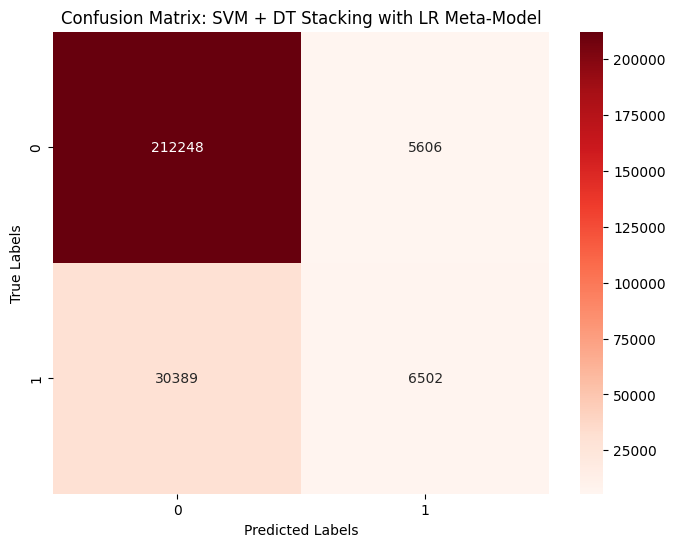

In [47]:
base_learners = [
    ('svm', SVC(kernel='linear', C=1, random_state=42)),
    ('dt', DecisionTreeClassifier(max_depth=5, random_state=42))
]

meta_model = LogisticRegression(random_state=42)

stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_model, cv=5, n_jobs=-1)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

stacking_pred_cv = cross_val_predict(stacking_clf, x_base_featured_scaled, y_base, cv=kfold)


cm = confusion_matrix(y_base, stacking_pred_cv)

print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=np.unique(y_base), yticklabels=np.unique(y_base))
plt.title("Confusion Matrix: SVM + DT Stacking with LR Meta-Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()